In [ ]:
!pip install xgboost lightgbm catboost scikit-learn pandas numpy matplotlib seaborn joblib optuna


In [ ]:
import os
import re
import math
import joblib
import time
from urllib.parse import urlparse, parse_qs

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.base import clone
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, confusion_matrix
from sklearn.pipeline import make_pipeline

try:
    from catboost import CatBoostClassifier
except Exception:
    raise ImportError("catboost is required. Install with `pip install catboost`")

try:
    import optuna
    HAS_OPTUNA = True
except Exception:
    HAS_OPTUNA = False

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [ ]:
DATA_PATH = "LegitPhish.csv"

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"{DATA_PATH} not found. Upload dataset to this path.")

df = pd.read_csv(DATA_PATH)
print("Loaded dataset shape:", df.shape)
display(df.head(3))


Loaded dataset shape: (101219, 18)


,URL,url_length,has_ip_address,dot_count,https_flag,url_entropy,token_count,subdomain_count,query_param_count,tld_length,path_length,has_hyphen_in_domain,number_of_digits,tld_popularity,suspicious_file_extension,domain_name_length,percentage_numeric_chars,ClassLabel
0,https://keraekken-loagginnusa.godaddysites.com/,47,0,2,1,4.250669,6,1,1,3,1,1,0,1,0,12,0.0,0.0
1,https://metamsk01lgiix.godaddysites.com/,40,0,2,1,4.196439,6,1,1,3,1,0,2,1,0,12,5.0,0.0
2,http://myglobaltech.in/,23,0,1,0,3.936180,5,0,1,2,1,0,0,0,0,12,0.0,0.0


In [ ]:
label_candidates = ['ClassLabel','classlabel','label','Label','Class','class','Class_Label','Class Label']
LABEL_COL = None
for c in label_candidates:
    if c in df.columns:
        LABEL_COL = c
        break
if LABEL_COL is None:
    LABEL_COL = df.columns[-1]
    print("Warning: using last column as label:", LABEL_COL)

desired_features = [
    'url_length','has_ip_address','dot_count','https_flag','url_entropy','token_count',
    'subdomain_count','query_param_count','tld_length','path_length','has_hyphen_in_domain',
    'number_of_digits','tld_popularity','suspicious_file_extension','domain_name_length',
    'percentage_numeric_chars'
]


present_desired = [c for c in desired_features if c in df.columns]
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if LABEL_COL in numeric_cols:
    numeric_cols.remove(LABEL_COL)

if len(present_desired) >= 6:
    FEATURE_COLS = present_desired
else:
    FEATURE_COLS = numeric_cols

print("Label column:", LABEL_COL)
print("Feature columns being used:", FEATURE_COLS)


Label column: ClassLabel
Feature columns being used: ['url_length', 'has_ip_address', 'dot_count', 'https_flag', 'url_entropy', 'token_count', 'subdomain_count', 'query_param_count', 'tld_length', 'path_length', 'has_hyphen_in_domain', 'number_of_digits', 'tld_popularity', 'suspicious_file_extension', 'domain_name_length', 'percentage_numeric_chars']


In [ ]:
df[LABEL_COL] = pd.to_numeric(df[LABEL_COL], errors='coerce')
print("Label NaNs before:", df[LABEL_COL].isna().sum())
df = df[df[LABEL_COL].notna()].copy()
df[LABEL_COL] = df[LABEL_COL].astype(int)
print("Label distribution:\n", df[LABEL_COL].value_counts())

for c in FEATURE_COLS:
    df[c] = pd.to_numeric(df[c], errors='coerce')
    if df[c].isna().sum() > 0:
        med = df[c].median()
        df[c].fillna(med, inplace=True)
        
print("Any feature NaNs left:", df[FEATURE_COLS].isnull().sum().sum())


Label NaNs before: 1
Label distribution:
 ClassLabel
0    63678
1    37540
Name: count, dtype: int64
Any feature NaNs left: 0


In [ ]:
X = df[FEATURE_COLS].copy()
y = df[LABEL_COL].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)
print("Train/Test shapes:", X_train.shape, X_test.shape)


Train/Test shapes: (80974, 16) (20244, 16)


In [ ]:

scaler_lr_base = StandardScaler().fit(X_train)
joblib.dump(scaler_lr_base, "scaler_lr_base.joblib")
print("Saved scaler_lr_base.joblib")


Saved scaler_lr_base.joblib


In [ ]:
cat = CatBoostClassifier(
    iterations=300,
    depth=6,
    learning_rate=0.05,
    loss_function='Logloss',
    random_seed=RANDOM_STATE,
    verbose=0
)

ext = ExtraTreesClassifier(
    n_estimators=400,
    max_depth=12,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    min_samples_leaf=3,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

lr = LogisticRegression(
    solver='saga',
    max_iter=3000,
    C=1.0,
    class_weight='balanced',
    random_state=RANDOM_STATE
)

base_models = [cat, ext, rf, lr]
print("Base models:", [m.__class__.__name__ for m in base_models])


Base models: ['CatBoostClassifier', 'ExtraTreesClassifier', 'RandomForestClassifier', 'LogisticRegression']


In [ ]:
from sklearn.model_selection import StratifiedKFold

def get_oof_preds(models, X_df, y_ser, X_holdout_df=None, n_splits=5, random_state=RANDOM_STATE):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    n = X_df.shape[0]
    m = len(models)
    oof_train = np.zeros((n, m))
    holdout_preds = np.zeros((X_holdout_df.shape[0], m)) if X_holdout_df is not None else None

    for i, model in enumerate(models):
        print(f"Generating OOF for model {i+1}/{m}: {model.__class__.__name__}")
        oof_model = np.zeros(n)
        if X_holdout_df is not None:
            holdout_fold_preds = np.zeros((X_holdout_df.shape[0], n_splits))
        for fold, (tr_idx, val_idx) in enumerate(skf.split(X_df, y_ser)):
            X_tr, X_val = X_df.iloc[tr_idx], X_df.iloc[val_idx]
            y_tr, y_val = y_ser.iloc[tr_idx], y_ser.iloc[val_idx]

            m_clone = clone(model)
            if isinstance(m_clone, LogisticRegression):
                scaler_local = StandardScaler()
                X_tr_sc = scaler_local.fit_transform(X_tr)
                X_val_sc = scaler_local.transform(X_val)
                m_clone.fit(X_tr_sc, y_tr)
                oof_model[val_idx] = m_clone.predict_proba(X_val_sc)[:,1]
                if X_holdout_df is not None:
                    holdout_fold_preds[:, fold] = m_clone.predict_proba(scaler_local.transform(X_holdout_df))[:,1]
            elif m_clone.__class__.__name__ == 'CatBoostClassifier':
                m_clone.fit(X_tr, y_tr, verbose=0)
                oof_model[val_idx] = m_clone.predict_proba(X_val)[:,1]
                if X_holdout_df is not None:
                    holdout_fold_preds[:, fold] = m_clone.predict_proba(X_holdout_df)[:,1]
            else:
                m_clone.fit(X_tr, y_tr)
                oof_model[val_idx] = m_clone.predict_proba(X_val)[:,1]
                if X_holdout_df is not None:
                    holdout_fold_preds[:, fold] = m_clone.predict_proba(X_holdout_df)[:,1]

            del m_clone
        oof_train[:, i] = oof_model
        if X_holdout_df is not None:
            holdout_preds[:, i] = holdout_fold_preds.mean(axis=1)

    return oof_train, holdout_preds


In [ ]:
oof_train, holdout_preds = get_oof_preds(base_models, X_train, y_train, X_holdout_df=X_test, n_splits=5)
print("OOF shapes:", oof_train.shape, holdout_preds.shape)


Generating OOF for model 1/4: CatBoostClassifier
Generating OOF for model 2/4: ExtraTreesClassifier
Generating OOF for model 3/4: RandomForestClassifier
Generating OOF for model 4/4: LogisticRegression
OOF shapes: (80974, 4) (20244, 4)


In [ ]:
meta_X_train = pd.DataFrame(oof_train, columns=['cat_pred','ext_pred','rf_pred','lr_pred'])
meta_X_test  = pd.DataFrame(holdout_preds, columns=['cat_pred','ext_pred','rf_pred','lr_pred'])

meta_scaler = StandardScaler().fit(meta_X_train)
joblib.dump(meta_scaler, "meta_scaler.joblib")
meta_X_train_scaled = meta_scaler.transform(meta_X_train)
meta_X_test_scaled  = meta_scaler.transform(meta_X_test)

meta_lr = LogisticRegression(solver='lbfgs', max_iter=1000, class_weight='balanced', random_state=RANDOM_STATE)
meta_lr.fit(meta_X_train_scaled, y_train)

meta_probs = meta_lr.predict_proba(meta_X_test_scaled)[:,1]
meta_preds = (meta_probs >= 0.5).astype(int)

print("Meta classification report:")
print(classification_report(y_test, meta_preds))
print("Meta ROC-AUC:", roc_auc_score(y_test, meta_probs))


Meta classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12736
           1       1.00      1.00      1.00      7508

    accuracy                           1.00     20244
   macro avg       1.00      1.00      1.00     20244
weighted avg       1.00      1.00      1.00     20244

Meta ROC-AUC: 0.9999985254422084


In [ ]:
print("Fitting final base models on full training set...")

cat_final = CatBoostClassifier(**{k:v for k,v in cat.get_params().items() if k in CatBoostClassifier().get_params()})
cat_final.fit(X_train, y_train, verbose=0)

ext_final = ExtraTreesClassifier(n_estimators=400, max_depth=12, n_jobs=-1, random_state=RANDOM_STATE)
ext_final.fit(X_train, y_train)

rf_final = RandomForestClassifier(n_estimators=300, max_depth=12, min_samples_leaf=3, n_jobs=-1, random_state=RANDOM_STATE)
rf_final.fit(X_train, y_train)

scaler_lr_base = joblib.load("scaler_lr_base.joblib")
lr_final = LogisticRegression(solver='saga', max_iter=3000, C=1.0, class_weight='balanced', random_state=RANDOM_STATE)
lr_final.fit(scaler_lr_base.transform(X_train), y_train)

meta_lr_final = meta_lr
print("Final models trained.")


Fitting final base models on full training set...
Final models trained.


In [ ]:
artifact = {
    'feature_columns': FEATURE_COLS,
    'base_cat': cat_final,
    'base_ext': ext_final,
    'base_rf': rf_final,
    'base_lr': lr_final,
    'meta_lr': meta_lr_final,
    'meta_scaler': meta_scaler
}
joblib.dump(artifact, "stacking_artifact_tuned.joblib", compress=3)
print("Saved stacking_artifact_tuned.joblib (~size: {:.2f} MB)".format(os.path.getsize("stacking_artifact_tuned.joblib")/1024/1024))


Saved stacking_artifact_tuned.joblib (~size: 3.69 MB)


In [ ]:
art = joblib.load("stacking_artifact_tuned.joblib")
p_cat = art['base_cat'].predict_proba(X_test)[:,1]
p_ext = art['base_ext'].predict_proba(X_test)[:,1]
p_rf  = art['base_rf'].predict_proba(X_test)[:,1]
p_lr  = art['base_lr'].predict_proba(joblib.load("scaler_lr_base.joblib").transform(X_test))[:,1]


meta_feats_test = np.vstack([p_cat, p_ext, p_rf, p_lr]).T
meta_feats_test_scaled = art['meta_scaler'].transform(meta_feats_test)
final_probs_legit = art['meta_lr'].predict_proba(meta_feats_test_scaled)[:,1]
final_preds = (final_probs_legit >= 0.5).astype(int)
final_probs_phishing = 1 - final_probs_legit

print("Final ensemble metrics (test):")
print(classification_report(y_test, final_preds))
print("ROC-AUC:", roc_auc_score(y_test, final_probs_legit))
print("Confusion matrix:\n", confusion_matrix(y_test, final_preds))


Final ensemble metrics (test):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12736
           1       1.00      1.00      1.00      7508

    accuracy                           1.00     20244
   macro avg       1.00      1.00      1.00     20244
weighted avg       1.00      1.00      1.00     20244

ROC-AUC: 0.9999985986472051
Confusion matrix:
 [[12724    12]
 [    5  7503]]


In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, meta_probs)
pr_auc = auc(recall, precision)
print("PR-AUC (meta):", pr_auc)

target_precision = 0.95
chosen_thr = 0.5
for p, r, t in zip(precision[::-1], recall[::-1], list(thresholds[::-1]) + [0.0]):
    if p >= target_precision:
        chosen_thr = t
        break
print("Chosen threshold for precision >= {:.2f} -> {:.4f}".format(target_precision, chosen_thr))


chosen_preds = (meta_probs >= chosen_thr).astype(int)
print(classification_report(y_test, chosen_preds))
print("Confusion matrix:\n", confusion_matrix(y_test, chosen_preds))


PR-AUC (meta): 0.9999975034600155
Chosen threshold for precision >= 0.95 -> 0.9999
              precision    recall  f1-score   support

           0       0.63      1.00      0.77     12736
           1       1.00      0.00      0.00      7508

    accuracy                           0.63     20244
   macro avg       0.81      0.50      0.39     20244
weighted avg       0.77      0.63      0.49     20244

Confusion matrix:
 [[12736     0]
 [ 7500     8]]


In [ ]:
import tldextract

def extract_features_from_url(url: str):
    parsed = urlparse(url)
    ext = tldextract.extract(url)
    domain = ext.domain or ""
    suffix = ext.suffix or ""
    subdomain = ext.subdomain or ""
    full_domain = ".".join(x for x in [subdomain, domain, suffix] if x)

    path = parsed.path or ""
    query = parsed.query or ""
    url_length = len(url)
    ip_pattern = r"(\d{1,3}\.){3}\d{1,3}"
    has_ip_address = 1 if re.search(ip_pattern, full_domain) else 0
    dot_count = url.count(".")
    https_flag = 1 if parsed.scheme == "https" else 0

    def shannon_entropy(s):
        if not s:
            return 0.0
        probs = [float(s.count(c)) / len(s) for c in set(s)]
        return -sum(p * math.log2(p) for p in probs)

    url_entropy = shannon_entropy(url)
    token_count = len(re.split(r'\W+', url))
    subdomain_count = len([x for x in subdomain.split('.') if x]) if subdomain else 0
    query_param_count = len(parse_qs(query))
    tld_length = len(suffix)
    path_length = len(path)
    has_hyphen_in_domain = 1 if '-' in full_domain else 0
    number_of_digits = sum(c.isdigit() for c in url)
    popular_tlds = {"com","org","net","in","co","edu","gov"}
    tld_popularity = 1 if suffix in popular_tlds else 0
    suspicious_exts = {".exe",".zip",".rar",".apk",".dll",".bat",".cmd",".scr"}
    suspicious_file_extension = 1 if any(url.lower().endswith(ext) for ext in suspicious_exts) else 0
    domain_name_length = len(domain)
    percentage_numeric_chars = sum(c.isdigit() for c in url) / len(url) if len(url)>0 else 0.0

    feat = {
        'url_length': url_length,
        'has_ip_address': has_ip_address,
        'dot_count': dot_count,
        'https_flag': https_flag,
        'url_entropy': url_entropy,
        'token_count': token_count,
        'subdomain_count': subdomain_count,
        'query_param_count': query_param_count,
        'tld_length': tld_length,
        'path_length': path_length,
        'has_hyphen_in_domain': has_hyphen_in_domain,
        'number_of_digits': number_of_digits,
        'tld_popularity': tld_popularity,
        'suspicious_file_extension': suspicious_file_extension,
        'domain_name_length': domain_name_length,
        'percentage_numeric_chars': percentage_numeric_chars
    }
    return feat


In [ ]:
import joblib
import pandas as pd

def predict_url(url: str):
    art = joblib.load("stacking_artifact_tuned.joblib")
    scaler_lr_base = joblib.load("scaler_lr_base.joblib")

    feat_cols = art["feature_columns"]
    feat_dict = extract_features_from_url(url)
    X_row = pd.DataFrame([feat_dict])[feat_cols]

    p_cat = art["base_cat"].predict_proba(X_row)[:, 1][0]
    p_et  = art["base_ext"].predict_proba(X_row)[:, 1][0] 
    p_rf  = art["base_rf"].predict_proba(X_row)[:, 1][0]


    X_lr = X_row.to_numpy()             # <-- FIX
    X_lr_scaled = scaler_lr_base.transform(X_lr)
    p_lr = art["base_lr"].predict_proba(X_lr_scaled)[:, 1][0]


    meta = pd.DataFrame([{
    "cat_pred": p_cat,
    "ext_pred": p_et,
    "rf_pred": p_rf,
    "lr_pred": p_lr
     }])
    meta_scaled = art["meta_scaler"].transform(meta)

    final_prob_legit = art["meta_lr"].predict_proba(meta_scaled)[0, 1]
    prob_phishing = 1 - final_prob_legit

    label_pred = 1 if final_prob_legit >= 0.5 else 0

    if prob_phishing < 0.10:
        risk = "Legitmate"
    elif prob_phishing < 0.40:
        risk = "Suspicious"
    else:
        risk = "Phishing"

    return {
        "url": url,
        "prob_phishing": float(prob_phishing),
        "prob_legitimate": float(final_prob_legit),
        "prediction_label": int(label_pred),
        "risk_level": risk,
        "base_model_scores": {
            "catboost": float(p_cat),
            "extratrees": float(p_et),
            "randomforest": float(p_rf),
            "logistic": float(p_lr)
        }
    }

print(predict_url("https://fktrbigbillos01.pages.dev/"))

{'url': 'https://fktrbigbillos01.pages.dev/', 'prob_phishing': 0.9483892238134203, 'prob_legitimate': 0.05161077618657977, 'prediction_label': 0, 'risk_level': 'Phishing', 'base_model_scores': {'catboost': 0.12915190563614673, 'extratrees': 0.7597144518280464, 'randomforest': 0.21257136048699604, 'logistic': 0.030895435125803467}}


In [ ]:
urls=["https://securepanel-authconnect.com","https://www.blueharborlabs.org","https://fintrxglobalservices.net","https://update-id-checker.info","https://www.hawthornebooks.com"]

for url in urls:
    result=predict_url(url)
    print(result)

{'url': 'https://securepanel-authconnect.com', 'prob_phishing': 0.07413439801173205, 'prob_legitimate': 0.925865601988268, 'prediction_label': 1, 'risk_level': 'Legitmate', 'base_model_scores': {'catboost': 0.8681602522072657, 'extratrees': 0.4194848427940039, 'randomforest': 0.761719287423378, 'logistic': 0.02042517905783194}}
{'url': 'https://www.blueharborlabs.org', 'prob_phishing': 0.0002212512960743096, 'prob_legitimate': 0.9997787487039257, 'prediction_label': 1, 'risk_level': 'Legitmate', 'base_model_scores': {'catboost': 0.9999546244165253, 'extratrees': 0.9981979190126543, 'randomforest': 0.9826944444444446, 'logistic': 0.7180204491892984}}
{'url': 'https://fintrxglobalservices.net', 'prob_phishing': 0.009914919095509234, 'prob_legitimate': 0.9900850809044908, 'prediction_label': 1, 'risk_level': 'Legitmate', 'base_model_scores': {'catboost': 0.940280830834419, 'extratrees': 0.6113817242793327, 'randomforest': 0.7696994461535367, 'logistic': 0.424828198226792}}
{'url': 'https:

In [ ]:
test_urls = [
    "https://www.microsoft.com",
    "https://www.wikipedia.org",
    "https://www.python.org/downloads/",
    "https://accounts.google.com",
    "https://www.nasa.gov",
    "https://www.healthline.com/nutrition/10-healthy-foods",
    "https://www.kaspersky.com",
    "https://www.bbc.com/news",
    "https://www.udemy.com/course/python-for-beginners/",
    "https://www.dropbox.com/login",
    "http://paypal-verification-center.com/login/update",
    "https://secure-google-login-auth.net",
    "https://appleid-confirm-secure.com",
    "https://update-account-info-security.com",
    "https://login-verify-amazon-support.live",
    "https://securebanking-authenticate.net/reset",
    "https://microsoftsupport-warning.com/security",
    "https://gov-id-verification-centers.org/login",
    "http://upgrade-paypal-account.com",
    "https://dropbox-security-checker.net/verify"
]

results = []

for url in test_urls:
    try:
        pred = predict_url(url)
        results.append(pred)
        print(pred)
    except Exception as e:
        print(f"Error predicting {url}: {e}")


{'url': 'https://www.microsoft.com', 'prob_phishing': 0.000194999966725784, 'prob_legitimate': 0.9998050000332742, 'prediction_label': 1, 'risk_level': 'Legitmate', 'base_model_scores': {'catboost': 0.9999718720452896, 'extratrees': 0.9985152064696559, 'randomforest': 0.9826929328429029, 'logistic': 0.7795028835768264}}
{'url': 'https://www.wikipedia.org', 'prob_phishing': 0.00018371218719026583, 'prob_legitimate': 0.9998162878128097, 'prediction_label': 1, 'risk_level': 'Legitmate', 'base_model_scores': {'catboost': 0.9999699390167255, 'extratrees': 0.9983785590796161, 'randomforest': 0.9826929328429029, 'logistic': 0.8091706972294416}}
{'url': 'https://www.python.org/downloads/', 'prob_phishing': 0.01841820182767362, 'prob_legitimate': 0.9815817981723264, 'prediction_label': 1, 'risk_level': 'Legitmate', 'base_model_scores': {'catboost': 0.8544762422999377, 'extratrees': 0.7507564633735606, 'randomforest': 0.7199552533992326, 'logistic': 0.1729510342034075}}
{'url': 'https://accounts

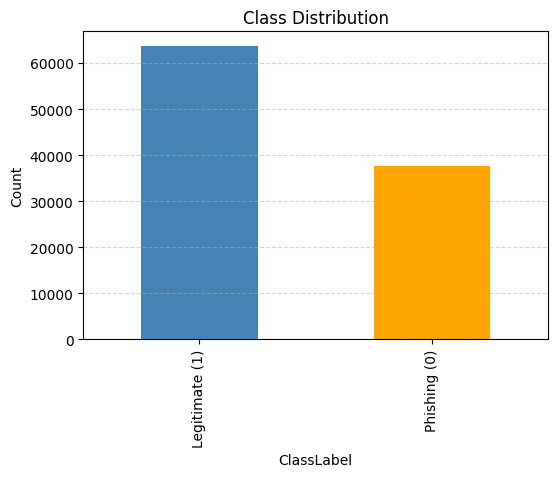

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
df['ClassLabel'].value_counts().plot(kind='bar', color=['steelblue','orange'])
plt.title("Class Distribution")
plt.xticks([0,1], ['Legitimate (1)','Phishing (0)'])
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


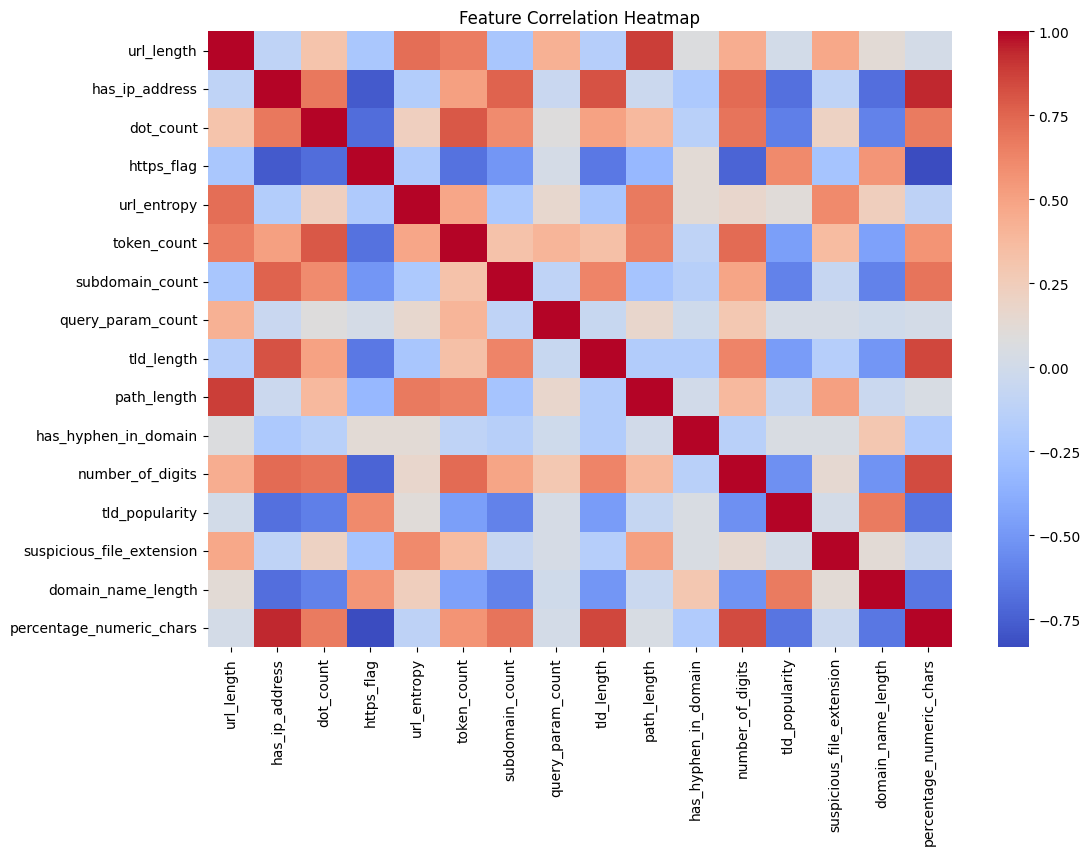

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
sns.heatmap(df[FEATURE_COLS].corr(), cmap='coolwarm', annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()


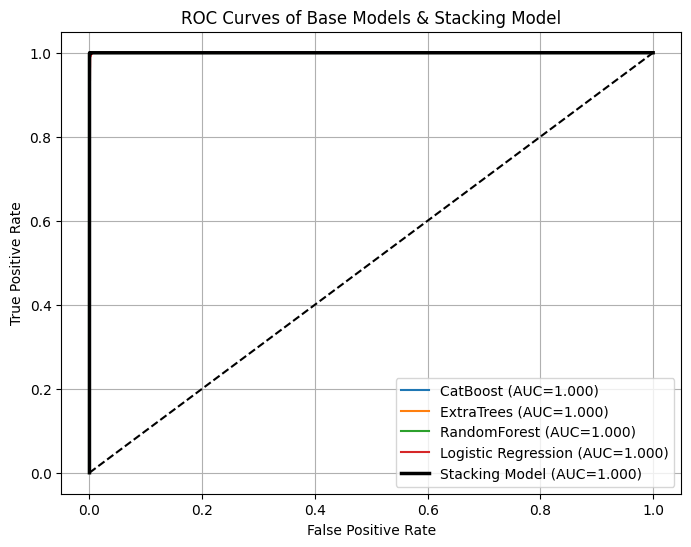

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

models = {
    "CatBoost": art["base_cat"],
    "ExtraTrees": art["base_ext"],
    "RandomForest": art["base_rf"],
    "Logistic Regression": art["base_lr"],
}

aucs_individual = {}

for name, model in models.items():
    if name == "Logistic Regression":
        X_scaled = scaler_lr_base.transform(X_test)
        prob = model.predict_proba(X_scaled)[:,1]
    else:
        prob = model.predict_proba(X_test)[:,1]

    fpr, tpr, _ = roc_curve(y_test, prob)
    roc_auc = auc(fpr, tpr)
    aucs_individual[name] = roc_auc 
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")

auc_cat = aucs_individual["CatBoost"]
auc_et = aucs_individual["ExtraTrees"]
auc_rf = aucs_individual["RandomForest"]
auc_lr = aucs_individual["Logistic Regression"]

meta_input = np.column_stack([
    models["CatBoost"].predict_proba(X_test)[:,1],
    models["ExtraTrees"].predict_proba(X_test)[:,1],
    models["RandomForest"].predict_proba(X_test)[:,1],
    models["Logistic Regression"].predict_proba(scaler_lr_base.transform(X_test))[:,1]
])

meta_scaled = art["meta_scaler"].transform(meta_input)
stack_proba = art["meta_lr"].predict_proba(meta_scaled)[:,1]
fpr_s, tpr_s, _ = roc_curve(y_test, stack_proba)
auc_s = auc(fpr_s, tpr_s)

plt.plot(fpr_s, tpr_s, linewidth=2.5, label=f"Stacking Model (AUC={auc_s:.3f})", color="black")

plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves of Base Models & Stacking Model")
plt.legend()
plt.grid(True)
plt.show()

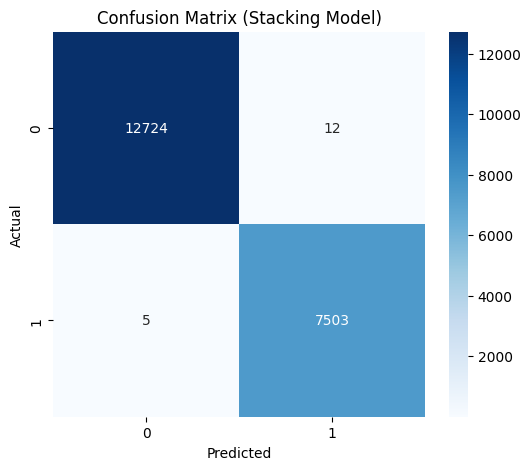

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = (stack_proba >= 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix (Stacking Model)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


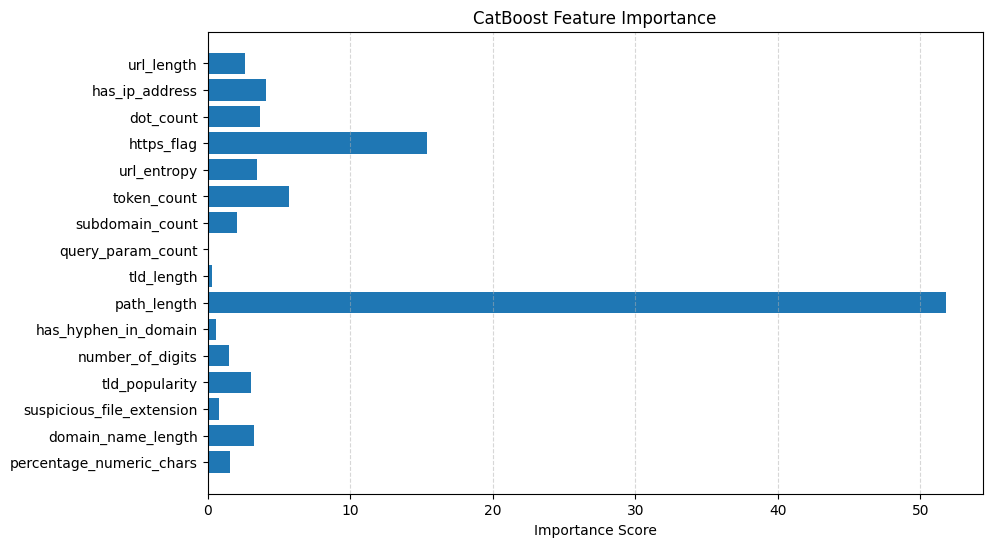

In [ ]:
cat = art["base_cat"]
importances = cat.get_feature_importance()
features = FEATURE_COLS

plt.figure(figsize=(10,6))
plt.barh(features, importances)
plt.title("CatBoost Feature Importance")
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()


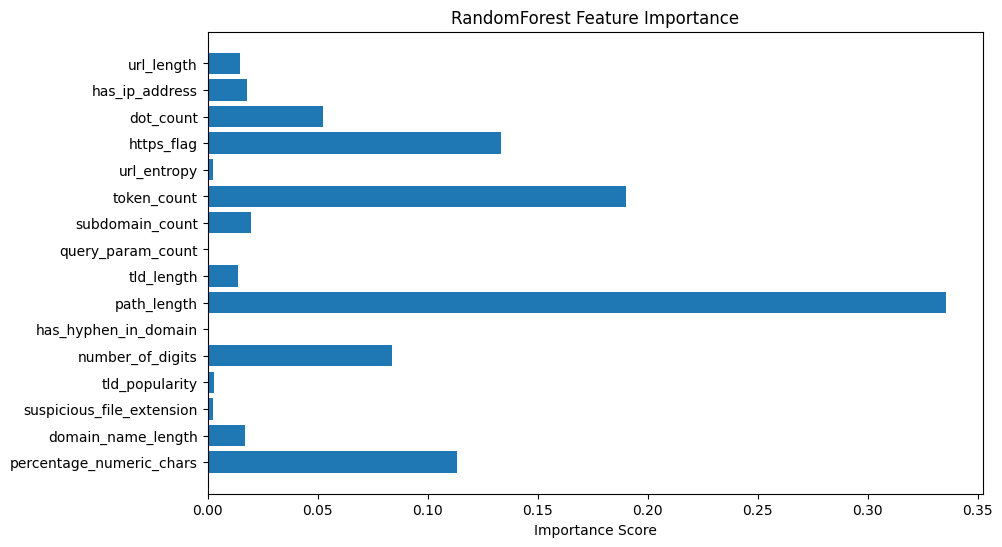

In [ ]:
rf = art["base_rf"]

plt.figure(figsize=(10,6))
plt.barh(FEATURE_COLS, rf.feature_importances_)
plt.title("RandomForest Feature Importance")
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()
plt.show()


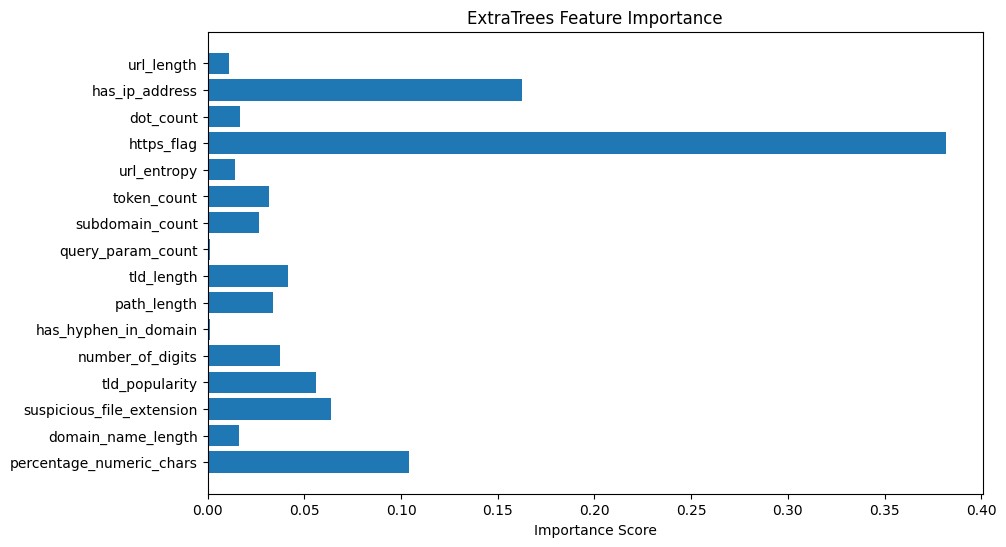

In [ ]:
et = art["base_ext"]

plt.figure(figsize=(10,6))
plt.barh(FEATURE_COLS, et.feature_importances_)
plt.title("ExtraTrees Feature Importance")
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()
plt.show()


In [ ]:
from sklearn.metrics import roc_auc_score

proba_cat = art["base_cat"].predict_proba(X_test)[:, 1]
auc_cat = roc_auc_score(y_test, proba_cat)

proba_et = art["base_ext"].predict_proba(X_test)[:, 1]
auc_et = roc_auc_score(y_test, proba_et)

proba_rf = art["base_rf"].predict_proba(X_test)[:, 1]
auc_rf = roc_auc_score(y_test, proba_rf)

X_lr_test = scaler_lr_base.transform(X_test)
proba_lr = art["base_lr"].predict_proba(X_lr_test)[:, 1]
auc_lr = roc_auc_score(y_test, proba_lr)

meta_input_test = np.column_stack([
    proba_cat,
    proba_et,
    proba_rf,
    proba_lr
])

meta_scaled_test = art["meta_scaler"].transform(meta_input_test)
proba_stack = art["meta_lr"].predict_proba(meta_scaled_test)[:, 1]
auc_s = roc_auc_score(y_test, proba_stack)

print("CatBoost AUC:", auc_cat)
print("ExtraTrees AUC:", auc_et)
print("RandomForest AUC:", auc_rf)
print("Logistic AUC:", auc_lr)
print("Stacking AUC:", auc_s)


CatBoost AUC: 0.9999983476586448
ExtraTrees AUC: 0.9999934742974329
RandomForest AUC: 0.9999988287200521
Logistic AUC: 0.9997233792330058
Stacking AUC: 0.9999985986472051


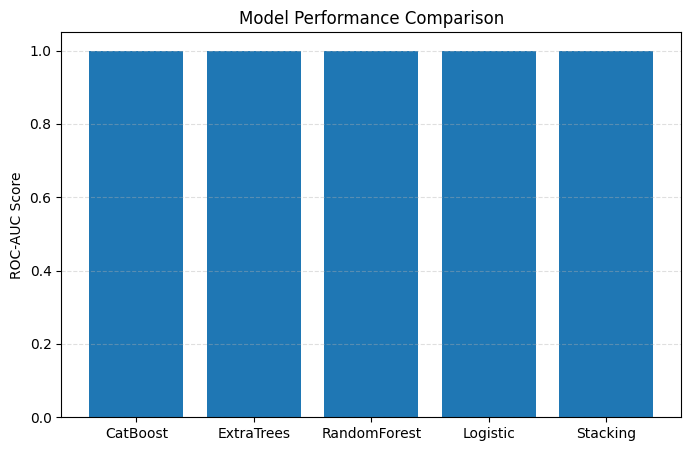

In [ ]:
names = ["CatBoost", "ExtraTrees", "RandomForest", "Logistic", "Stacking"]
aucs = [auc_cat, auc_et, auc_rf, auc_lr, auc_s]

plt.figure(figsize=(8,5))
plt.bar(names, aucs)
plt.ylabel("ROC-AUC Score")
plt.title("Model Performance Comparison")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()

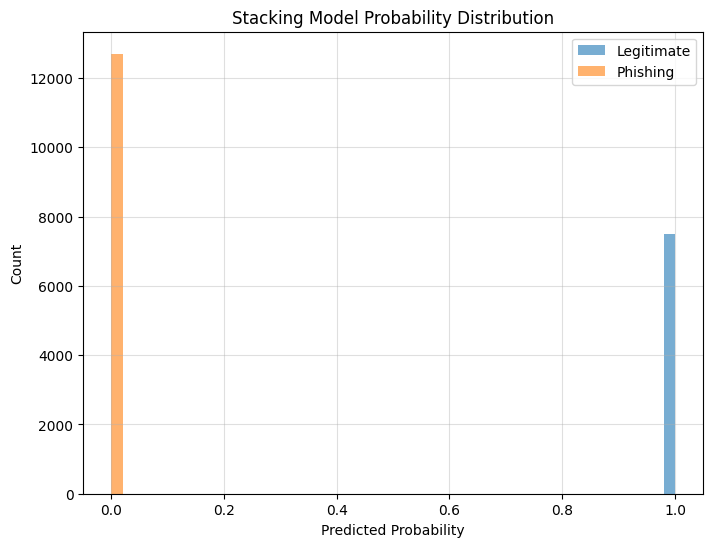

In [ ]:
plt.figure(figsize=(8,6))

plt.hist(proba_stack[y_test==1], bins=50, alpha=0.6, label="Legitimate")
plt.hist(proba_stack[y_test==0], bins=50, alpha=0.6, label="Phishing")

plt.title("Stacking Model Probability Distribution")
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.legend()
plt.grid(alpha=0.4)
plt.show()


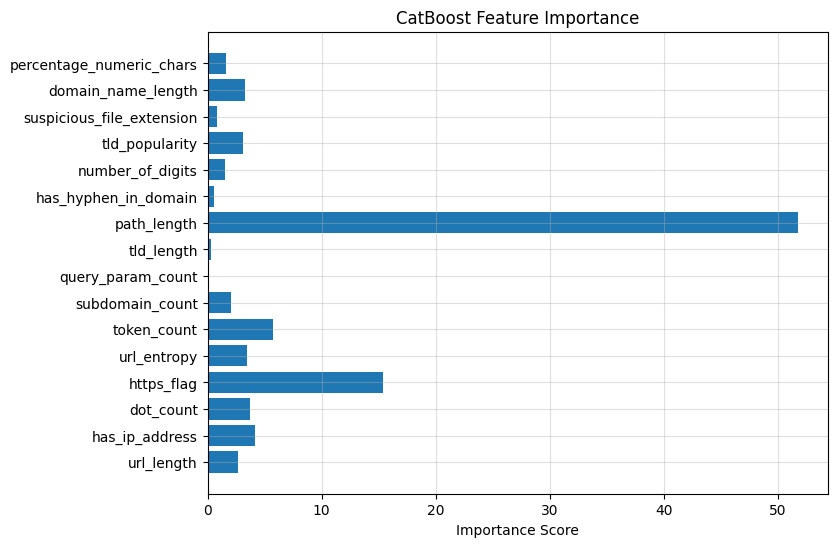

In [ ]:
importances = art["base_cat"].get_feature_importance()
plt.figure(figsize=(8,6))
plt.barh(FEATURE_COLS, importances)
plt.title("CatBoost Feature Importance")
plt.xlabel("Importance Score")
plt.grid(alpha=0.4)
plt.show()


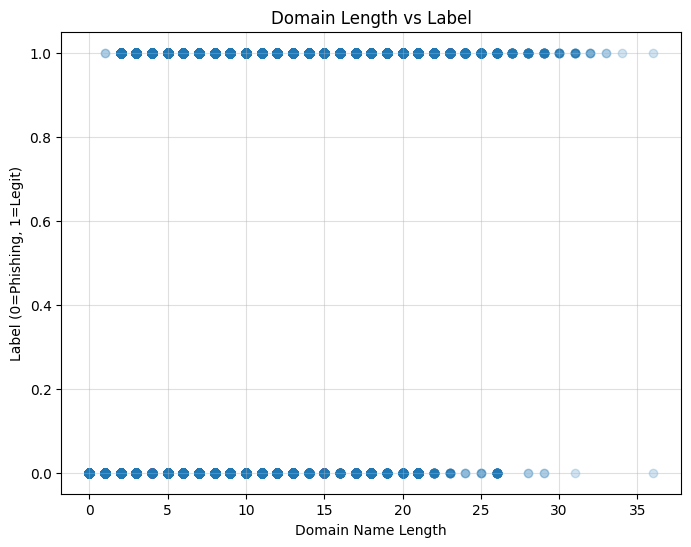

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(df['domain_name_length'], df['ClassLabel'], alpha=0.2)
plt.xlabel("Domain Name Length")
plt.ylabel("Label (0=Phishing, 1=Legit)")
plt.title("Domain Length vs Label")
plt.grid(alpha=0.4)
plt.show()


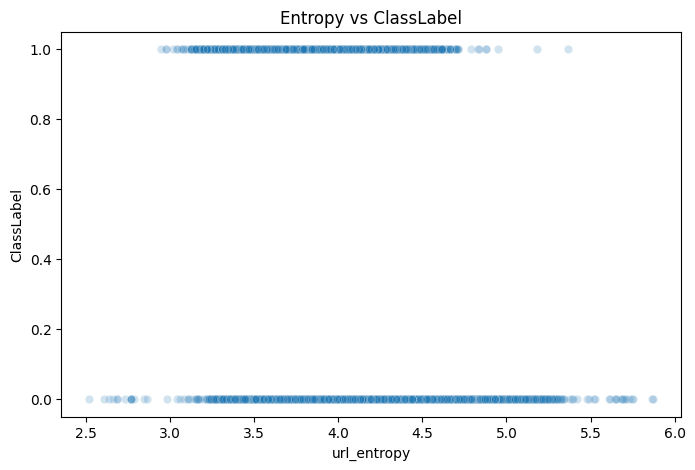

In [ ]:
plt.figure(figsize=(8,5))
sns.scatterplot(x=df["url_entropy"], y=df["ClassLabel"], alpha=0.2)
plt.title("Entropy vs ClassLabel")
plt.show()


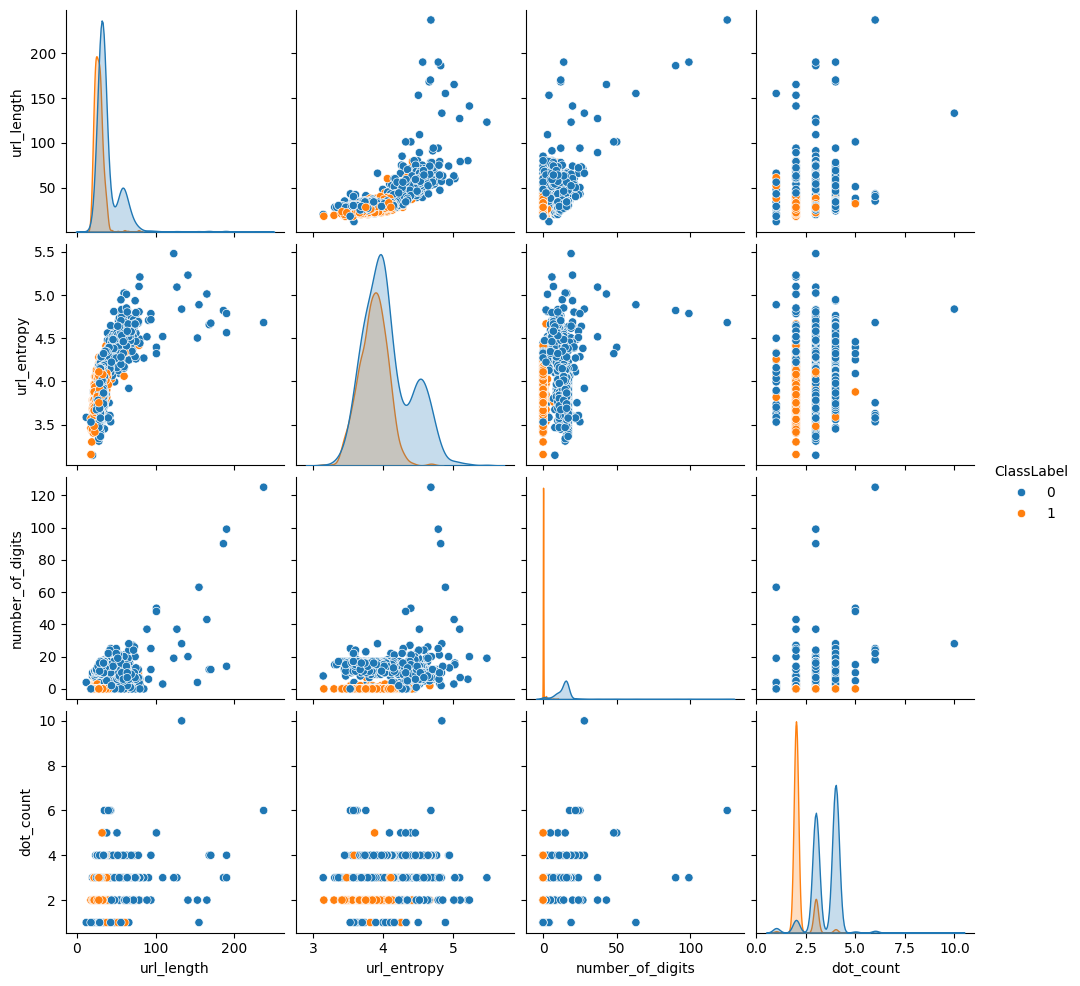

In [ ]:
sns.pairplot(df.sample(2000), vars=["url_length","url_entropy","number_of_digits","dot_count"], hue="ClassLabel")
plt.show()

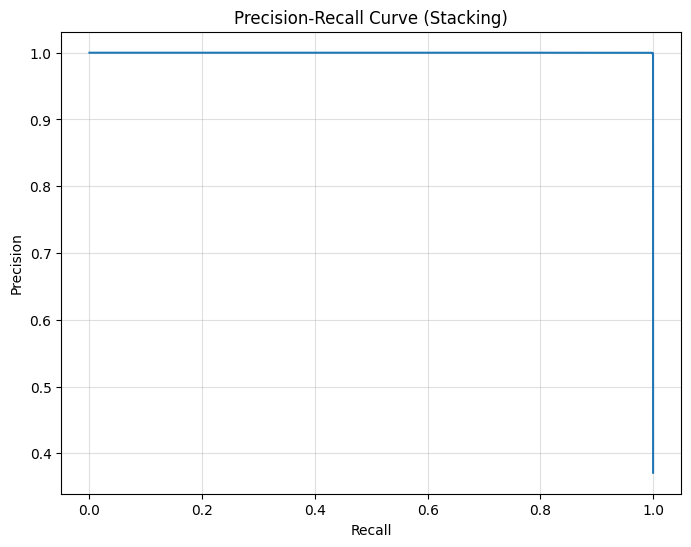

In [ ]:
from sklearn.metrics import precision_recall_curve

prec, rec, _ = precision_recall_curve(y_test, proba_stack)

plt.figure(figsize=(8,6))
plt.plot(rec, prec)
plt.title("Precision-Recall Curve (Stacking)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(alpha=0.4)
plt.show()


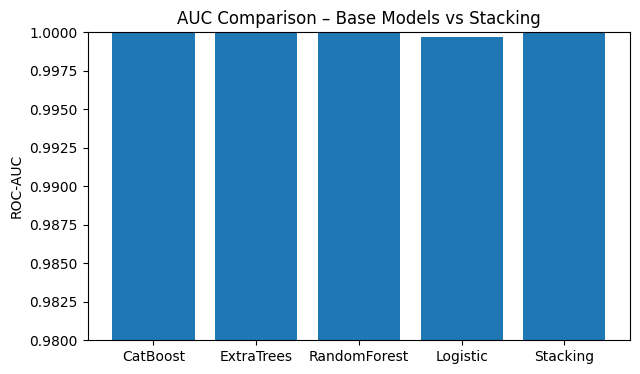

In [ ]:
names = ["CatBoost", "ExtraTrees", "RandomForest", "Logistic", "Stacking"]
aucs = [auc_cat, auc_et, auc_rf, auc_lr, auc_s]

plt.figure(figsize=(7,4))
plt.bar(names, aucs)
plt.ylim(0.98, 1)
plt.title("AUC Comparison – Base Models vs Stacking")
plt.ylabel("ROC-AUC")
plt.show()


/tmp/ipython-input-3648192203.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test)


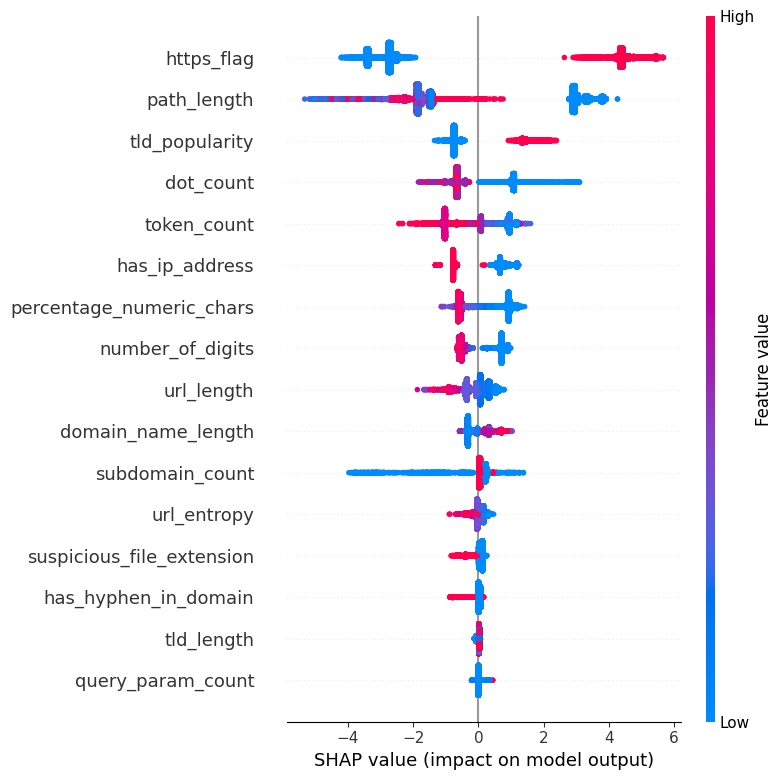

In [ ]:
import shap

explainer = shap.TreeExplainer(art["base_cat"])
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)


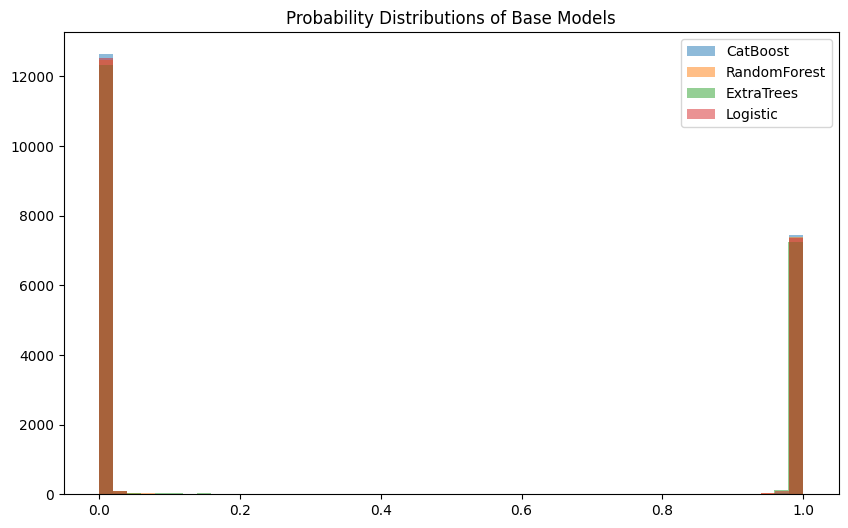

In [ ]:
plt.figure(figsize=(10,6))
plt.hist(proba_cat, bins=50, alpha=0.5, label="CatBoost")
plt.hist(proba_rf, bins=50, alpha=0.5, label="RandomForest")
plt.hist(proba_et, bins=50, alpha=0.5, label="ExtraTrees")
plt.hist(proba_lr, bins=50, alpha=0.5, label="Logistic")
plt.legend()
plt.title("Probability Distributions of Base Models")
plt.show()


In [ ]:

proba_cat_test = art["base_cat"].predict_proba(X_test)[:, 1]
proba_et_test  = art["base_ext"].predict_proba(X_test)[:, 1]
proba_rf_test  = art["base_rf"].predict_proba(X_test)[:, 1]

X_lr_test = scaler_lr_base.transform(X_test.to_numpy())
proba_lr_test = art["base_lr"].predict_proba(X_lr_test)[:, 1]

meta_test = np.column_stack([
    proba_cat_test,
    proba_et_test,
    proba_rf_test,
    proba_lr_test
])

meta_test_scaled = art["meta_scaler"].transform(meta_test)


proba_stack = art["meta_lr"].predict_proba(meta_test_scaled)[:, 1]

stack_pred = (proba_stack >= 0.5).astype(int)


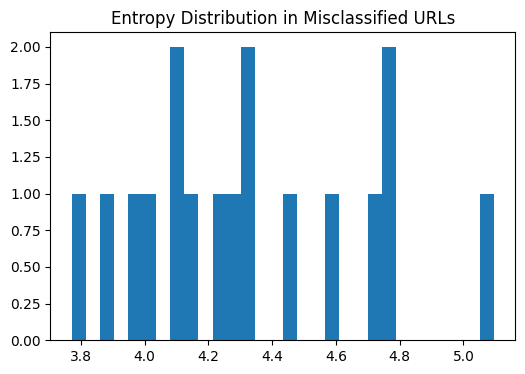

In [ ]:
misclassified = X_test[stack_pred != y_test]
plt.figure(figsize=(6,4))
plt.hist(misclassified["url_entropy"], bins=30)
plt.title("Entropy Distribution in Misclassified URLs")
plt.show()


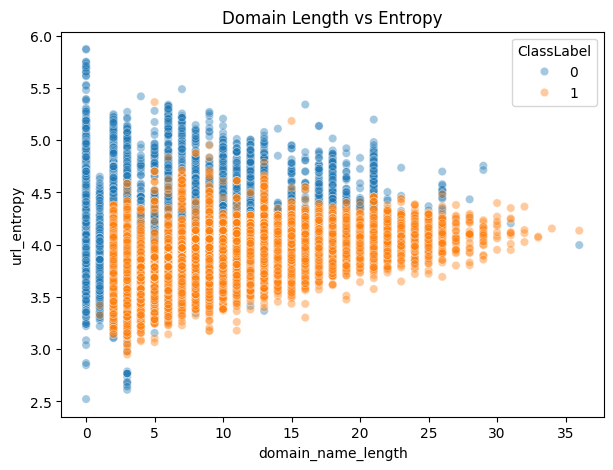

In [ ]:
plt.figure(figsize=(7,5))
sns.scatterplot(x=df["domain_name_length"], y=df["url_entropy"], hue=df["ClassLabel"], alpha=0.4)
plt.title("Domain Length vs Entropy")
plt.show()
